In [2]:
import numpy as np
from utils import open_llc2160, compute_land_ocean_mask3d, apply_land_ocean_mask
import matplotlib.pyplot as plt

In [4]:
db_theta = open_llc2160("theta")

time = 0
quality = -10

theta_3d = db_theta.read(time=time, quality=quality, x=[1000, 2000], y=[1000, 2000], z=[0, 1])

# Pass spatial extents to mask function so it matches theta_3d shape
mask_3d = compute_land_ocean_mask3d(
    time=time,
    quality=quality,
    x_range=[1000, 2000],
    y_range=[1000, 2000],
    z_range=[0, 1])

theta3d_ocean = apply_land_ocean_mask(theta_3d, mask_3d, land_value=np.nan)


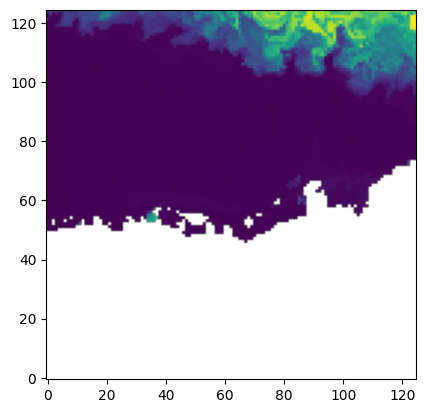

In [5]:
plt.imshow(theta3d_ocean[0,:,:],origin='lower')

In [14]:
def analyze_and_plot_ocean_data(
    variable_name="theta",
    time=0,
    quality=-10,
    x_range=[1000, 2000],
    y_range=[1000, 2000],
    z_range=[0, 1],
    z_slice=0,
    cmap='viridis',
    figsize=(12, 5)
):
    """
    Load ocean data, apply land/ocean mask, compute statistics, and generate plots.
    
    Parameters:
    -----------
    variable_name : str
        Variable to load (e.g., 'theta', 'salt')
    time : int
        Time step index
    quality : int
        Quality level for OpenVisus read
    x_range : list
        [x_min, x_max] grid indices
    y_range : list
        [y_min, y_max] grid indices
    z_range : list
        [z_min, z_max] depth indices
    z_slice : int
        Depth slice to visualize (default: 0 for surface)
    cmap : str
        Matplotlib colormap name
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    dict with keys:
        - 'data': masked 3D array
        - 'statistics': dict with min, max, mean, std, median, percentiles
        - 'fig': matplotlib figure object
    """
    # Load dataset
    db = open_llc2160(variable_name)
    
    # Read data
    data_3d = db.read(
        time=time,
        quality=quality,
        x=x_range,
        y=y_range,
        z=z_range
    )
    
    # Compute matching mask
    mask_3d = compute_land_ocean_mask3d(
        time=time,
        quality=quality,
        x_range=x_range,
        y_range=y_range,
        z_range=z_range
    )
    
    # Apply mask
    masked_data = apply_land_ocean_mask(data_3d, mask_3d, land_value=np.nan)
    
    # Compute statistics (ignoring NaN values)
    valid_data = masked_data[~np.isnan(masked_data)]
    
    stats = {
        'min': np.min(valid_data),
        'max': np.max(valid_data),
        'mean': np.mean(valid_data),
        'std': np.std(valid_data),
        'median': np.median(valid_data),
        'percentile_25': np.percentile(valid_data, 25),
        'percentile_75': np.percentile(valid_data, 75),
        'percentile_95': np.percentile(valid_data, 95),
        'count_valid': len(valid_data),
        'count_land': np.sum(np.isnan(masked_data))
    }
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Spatial map
    im = ax1.imshow(masked_data[z_slice, :, :], origin='lower', cmap=cmap)
    ax1.set_title(f'{variable_name} at z={z_slice}')
    ax1.set_xlabel('X Index')
    ax1.set_ylabel('Y Index')
    plt.colorbar(im, ax=ax1, label=variable_name)
    
    # Plot 2: Histogram
    ax2.hist(valid_data, bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(stats['min'], color='blue', linestyle='--', linewidth=2, label=f"Min: {stats['min']:.2f}")
    ax2.axvline(stats['max'], color='orange', linestyle='--', linewidth=2, label=f"Max: {stats['max']:.2f}")
    ax2.axvline(stats['mean'], color='r', linestyle='--', linewidth=2, label=f"Mean: {stats['mean']:.2f}")
    ax2.axvline(stats['median'], color='g', linestyle='--', linewidth=2, label=f"Median: {stats['median']:.2f}")
    ax2.set_xlabel(f'{variable_name} Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution (Ocean Only)')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Print statistics
    print(f"=== {variable_name.upper()} Statistics ===")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Std: {stats['std']:.2f}")
    print(f"Median: {stats['median']:.2f}")
    print(f"25th Percentile: {stats['percentile_25']:.2f}")
    print(f"75th Percentile: {stats['percentile_75']:.2f}")
    print(f"95th Percentile: {stats['percentile_95']:.2f}")
    print(f"Valid Ocean Points: {stats['count_valid']:,}")
    print(f"Land/Masked Points: {stats['count_land']:,}")
    
    return {
        'data': masked_data,
        'statistics': stats,
        'fig': fig
    }

# RED SEA GROUND TRUTH

=== SALT Statistics (Ocean Only) ===
Min: 35.92
Max: 43.29
Mean: 39.32
Std: 1.07
Median: 39.40
25th Percentile: 38.77
75th Percentile: 40.17
95th Percentile: 40.35
Valid Ocean Points: 24,743
Land/Masked Points: 120,697


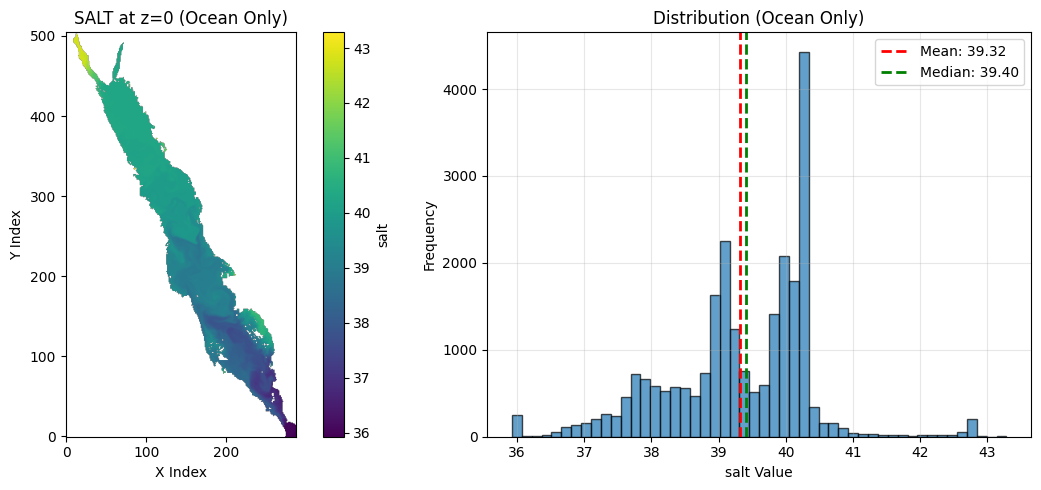

In [13]:
# Example usage:
result = analyze_and_plot_ocean_data(
    variable_name="salt",
    time=288,
    quality=0,
    x_range = [1680, 1968],  # Use these exact indices
    y_range = [4274, 4779],
    z_range = [0, 1],  # surface layer only
    z_slice=0
)

# Access results
# result['data']        -> 3D masked array
# result['statistics']  -> dict with all stats
# result['fig']         -> matplotlib figure

# INDIAN IOCEAN

=== THETA Statistics ===
Min: 1.59
Max: 35.41
Mean: 22.26
Std: 8.23
Median: 25.12
25th Percentile: 16.24
75th Percentile: 29.26
95th Percentile: 31.19
Valid Ocean Points: 3,934,628
Land/Masked Points: 1,638,172
=== THETA Statistics ===
Min: 0.92
Max: 34.25
Mean: 21.39
Std: 8.53
Median: 23.76
25th Percentile: 14.81
75th Percentile: 28.94
95th Percentile: 31.22
Valid Ocean Points: 3,934,628
Land/Masked Points: 1,638,172
=== THETA Statistics ===
Min: 0.92
Max: 34.25
Mean: 21.39
Std: 8.53
Median: 23.76
25th Percentile: 14.81
75th Percentile: 28.94
95th Percentile: 31.22
Valid Ocean Points: 3,934,628
Land/Masked Points: 1,638,172


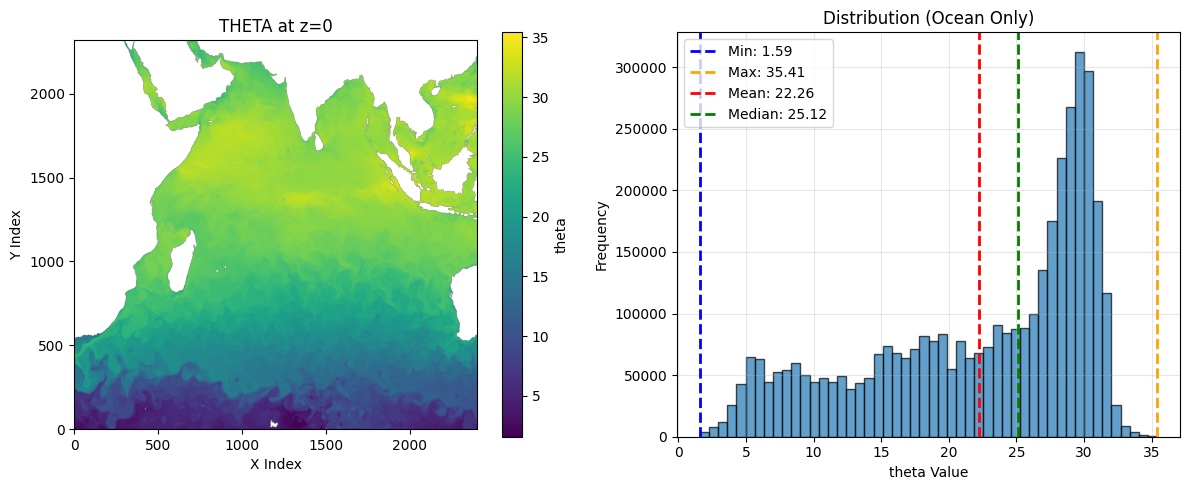

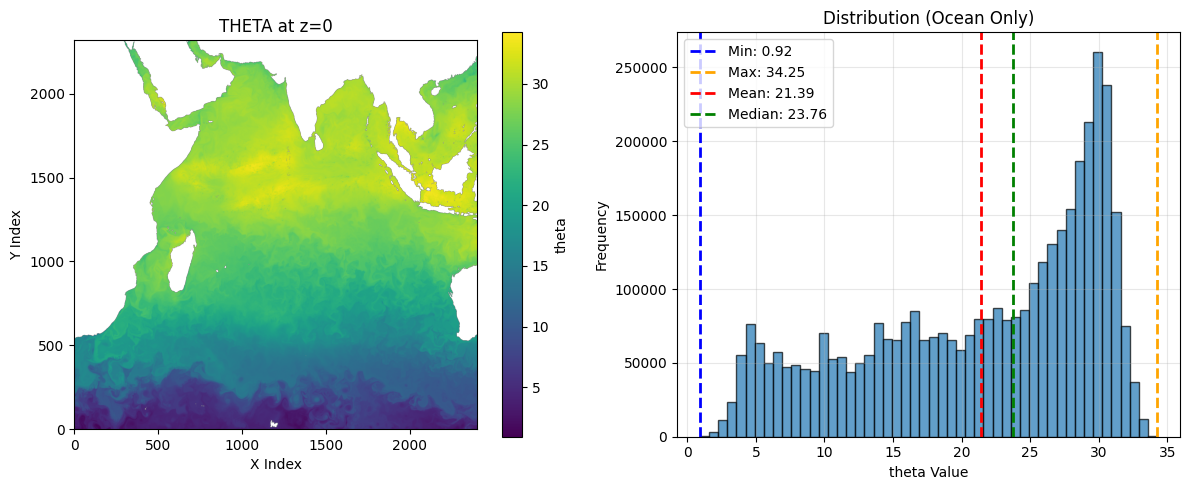

In [16]:

# "timestep_may": 2796, "timestep_nov": 7212
result_may = analyze_and_plot_ocean_data(
    variable_name="theta",
    time=2796,
    quality=0,
    x_range = [1392, 3792],  # Use these exact indices
    y_range = [2457, 4779],
    z_range = [0, 1],  # surface layer only
    z_slice=0
)

# "timestep_may": 2796, "timestep_nov": 7212
result_nov = analyze_and_plot_ocean_data(
    variable_name="theta",
    time=7212,
    quality=0,
    x_range = [1392, 3792],  # Use these exact indices
    y_range = [2457, 4779],
    z_range = [0, 1],  # surface layer only
    z_slice=0
)



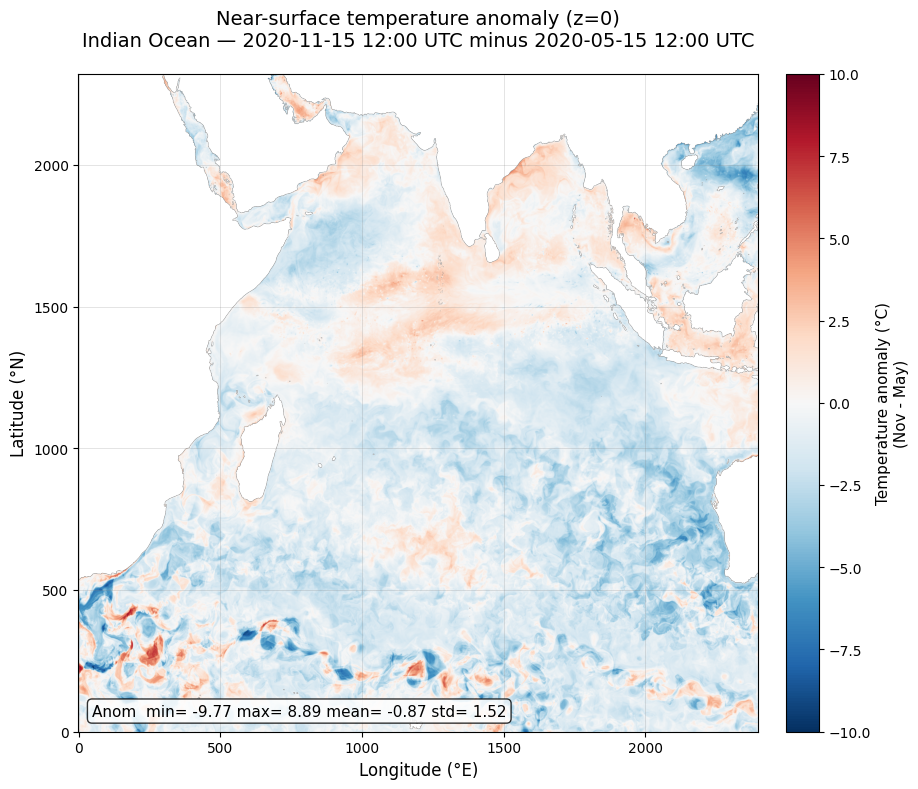


=== Temperature Anomaly Statistics (Nov - May) ===
Min: -9.77°C
Max: 8.89°C
Mean: -0.87°C
Std: 1.52°C


In [17]:
# Compute anomaly (November - May)
anomaly = result_nov['data'] - result_may['data']

# Compute anomaly statistics
valid_anomaly = anomaly[~np.isnan(anomaly)]

anom_stats = {
    'min': np.min(valid_anomaly),
    'max': np.max(valid_anomaly),
    'mean': np.mean(valid_anomaly),
    'std': np.std(valid_anomaly)
}

# Create figure matching the reference style
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot anomaly
im = ax.imshow(anomaly[0, :, :], origin='lower', cmap='RdBu_r', vmin=-10, vmax=10)

# Add title matching reference
ax.set_title(
    'Near-surface temperature anomaly (z=0)\n'
    'Indian Ocean — 2020-11-15 12:00 UTC minus 2020-05-15 12:00 UTC',
    fontsize=14,
    pad=20
)

# Labels
ax.set_xlabel('Longitude (°E)', fontsize=12)
ax.set_ylabel('Latitude (°N)', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Temperature anomaly\n(Nov - May)', pad=0.02)
cbar.set_label('Temperature anomaly (°C)\n(Nov - May)', fontsize=11)

# Add statistics text on plot
stats_text = f"Anom  min= {anom_stats['min']:.2f} max= {anom_stats['max']:.2f} mean= {anom_stats['mean']:.2f} std= {anom_stats['std']:.2f}"
ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Grid
ax.grid(True, alpha=0.3, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"\n=== Temperature Anomaly Statistics (Nov - May) ===")
print(f"Min: {anom_stats['min']:.2f}°C")
print(f"Max: {anom_stats['max']:.2f}°C")
print(f"Mean: {anom_stats['mean']:.2f}°C")
print(f"Std: {anom_stats['std']:.2f}°C")

# Mediterrnean sea

=== THETA Statistics ===
Min: 14.98
Max: 28.39
Mean: 22.86
Std: 2.21
Median: 23.08
25th Percentile: 21.29
75th Percentile: 24.33
95th Percentile: 26.15
Valid Ocean Points: 207,679
Land/Masked Points: 327,569


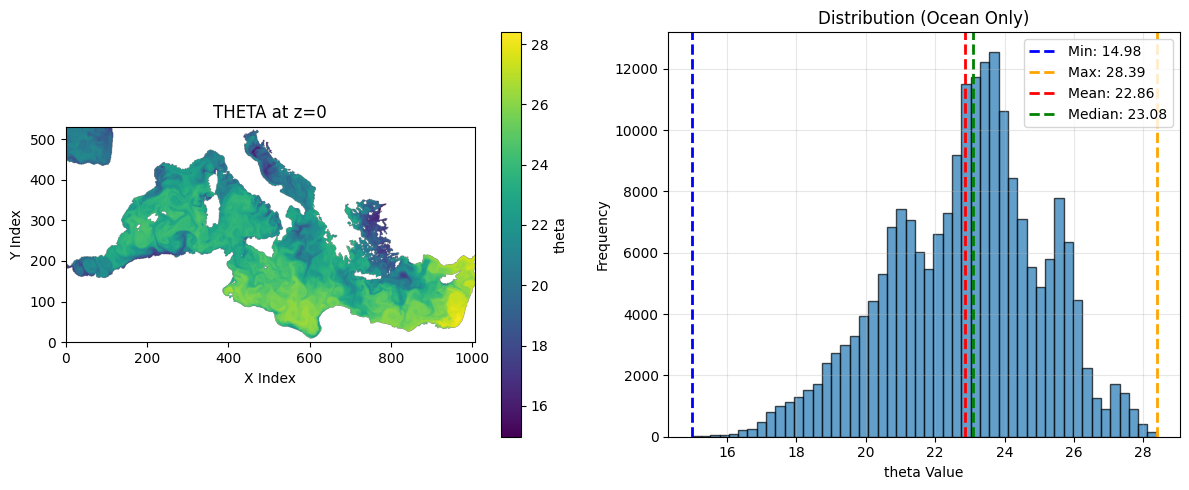

In [20]:
# "timestep_may": 2796, "timestep_nov": 7212
result_3 = analyze_and_plot_ocean_data(
    variable_name="theta",
    time=6468,
    quality=0,
    x_range = [768, 1776],  # Use these exact indices
    y_range = [4779,5310],
    z_range = [0, 1],  # surface layer only
    z_slice=0
)


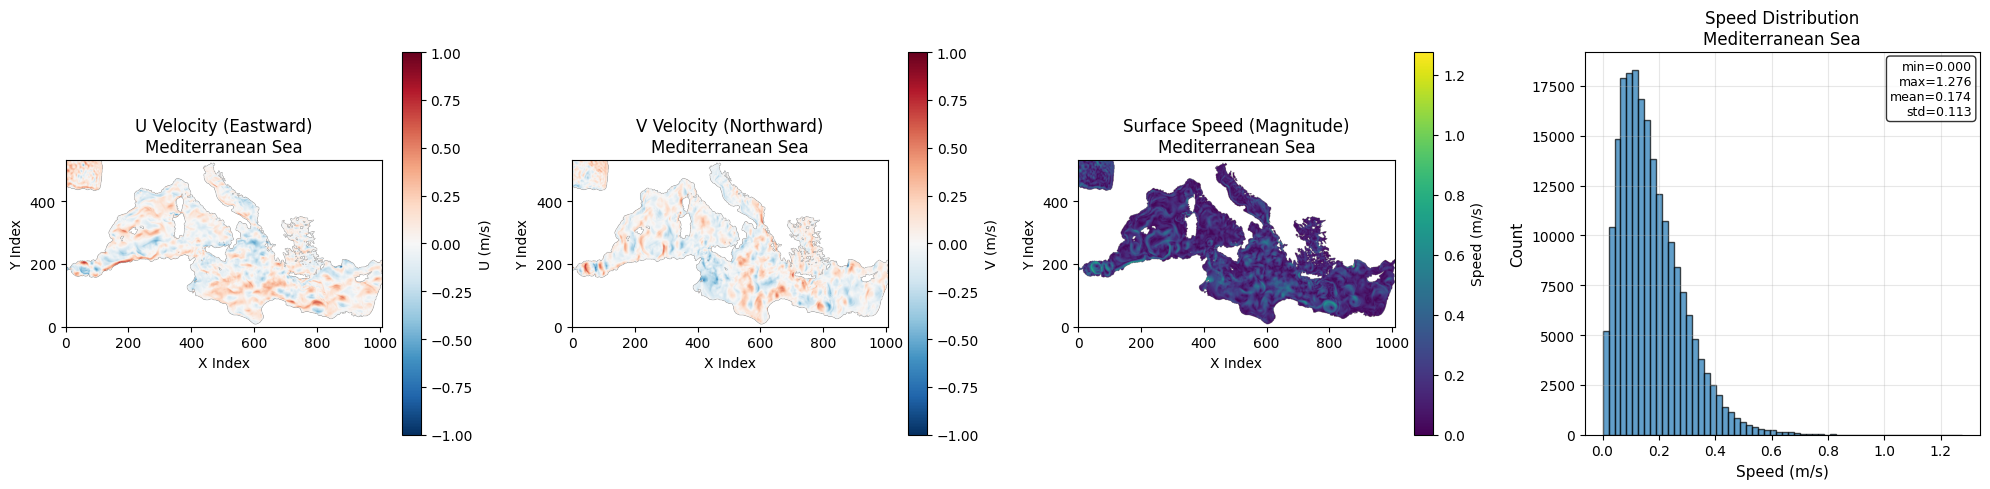

=== Surface Velocity Statistics (Mediterranean Sea) ===

Speed (Magnitude):
  Min: 0.0000 m/s
  Max: 1.2763 m/s
  Mean: 0.1740 m/s
  Median: 0.1517 m/s
  Std: 0.1126 m/s

U Component (Eastward):
  Mean: 0.0230 m/s
  Std: 0.1462 m/s

V Component (Northward):
  Mean: -0.0013 m/s
  Std: 0.1451 m/s


In [27]:
# Surface velocity calculation for Mediterranean Sea region
# Load U (eastward) and V (northward) velocity components

# Region parameters
time = 6468
quality = 0
x_range = [768, 1776]
y_range = [4779, 5310]
z_range = [0, 1]  # surface only

# Load U velocity (eastward)
db_u = open_llc2160("u")
u_3d = db_u.read(time=time, quality=quality, x=x_range, y=y_range, z=z_range)

# Load V velocity (northward)
db_v = open_llc2160("v")
v_3d = db_v.read(time=time, quality=quality, x=x_range, y=y_range, z=z_range)

# Compute matching mask
mask_3d = compute_land_ocean_mask3d(
    time=time,
    quality=quality,
    x_range=x_range,
    y_range=y_range,
    z_range=z_range
)

# Apply mask to velocity components
u_ocean = apply_land_ocean_mask(u_3d, mask_3d, land_value=np.nan)
v_ocean = apply_land_ocean_mask(v_3d, mask_3d, land_value=np.nan)

# Compute surface velocity magnitude (speed)
velocity_magnitude = np.sqrt(u_ocean**2 + v_ocean**2)

# Extract surface slice
u_surface = u_ocean[0, :, :]
v_surface = v_ocean[0, :, :]
speed_surface = velocity_magnitude[0, :, :]

# Compute statistics
valid_speed = speed_surface[~np.isnan(speed_surface)]
valid_u = u_surface[~np.isnan(u_surface)]
valid_v = v_surface[~np.isnan(v_surface)]

velocity_stats = {
    'speed_min': np.min(valid_speed),
    'speed_max': np.max(valid_speed),
    'speed_mean': np.mean(valid_speed),
    'speed_std': np.std(valid_speed),
    'speed_median': np.median(valid_speed),
    'u_mean': np.mean(valid_u),
    'u_std': np.std(valid_u),
    'v_mean': np.mean(valid_v),
    'v_std': np.std(valid_v)
}

# Visualization: U, V, Speed maps + Speed histogram
fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# Plot 1: U component
im1 = ax1.imshow(u_surface, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('U Velocity (Eastward)\nMediterranean Sea')
ax1.set_xlabel('X Index')
ax1.set_ylabel('Y Index')
plt.colorbar(im1, ax=ax1, label='U (m/s)')

# Plot 2: V component
im2 = ax2.imshow(v_surface, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('V Velocity (Northward)\nMediterranean Sea')
ax2.set_xlabel('X Index')
ax2.set_ylabel('Y Index')
plt.colorbar(im2, ax=ax2, label='V (m/s)')

# Plot 3: Speed (magnitude)
im3 = ax3.imshow(speed_surface, origin='lower', cmap='viridis')
ax3.set_title('Surface Speed (Magnitude)\nMediterranean Sea')
ax3.set_xlabel('X Index')
ax3.set_ylabel('Y Index')
plt.colorbar(im3, ax=ax3, label='Speed (m/s)')

# Plot 4: Speed histogram
ax4.hist(valid_speed, bins=60, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Speed (m/s)', fontsize=11)
ax4.set_ylabel('Count', fontsize=11)
ax4.set_title('Speed Distribution\nMediterranean Sea', fontsize=12)
ax4.grid(alpha=0.3)

# Add statistics text on histogram
speed_text = f"min={np.min(valid_speed):.3f}\nmax={np.max(valid_speed):.3f}\nmean={np.mean(valid_speed):.3f}\nstd={np.std(valid_speed):.3f}"
ax4.text(0.98, 0.98, speed_text, transform=ax4.transAxes, 
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print statistics
print(f"=== Surface Velocity Statistics (Mediterranean Sea) ===")
print(f"\nSpeed (Magnitude):")
print(f"  Min: {velocity_stats['speed_min']:.4f} m/s")
print(f"  Max: {velocity_stats['speed_max']:.4f} m/s")
print(f"  Mean: {velocity_stats['speed_mean']:.4f} m/s")
print(f"  Median: {velocity_stats['speed_median']:.4f} m/s")
print(f"  Std: {velocity_stats['speed_std']:.4f} m/s")
print(f"\nU Component (Eastward):")
print(f"  Mean: {velocity_stats['u_mean']:.4f} m/s")
print(f"  Std: {velocity_stats['u_std']:.4f} m/s")
print(f"\nV Component (Northward):")
print(f"  Mean: {velocity_stats['v_mean']:.4f} m/s")
print(f"  Std: {velocity_stats['v_std']:.4f} m/s")

# Store results
velocity_result = {
    'u': u_ocean,
    'v': v_ocean,
    'speed': velocity_magnitude,
    'statistics': velocity_stats
}

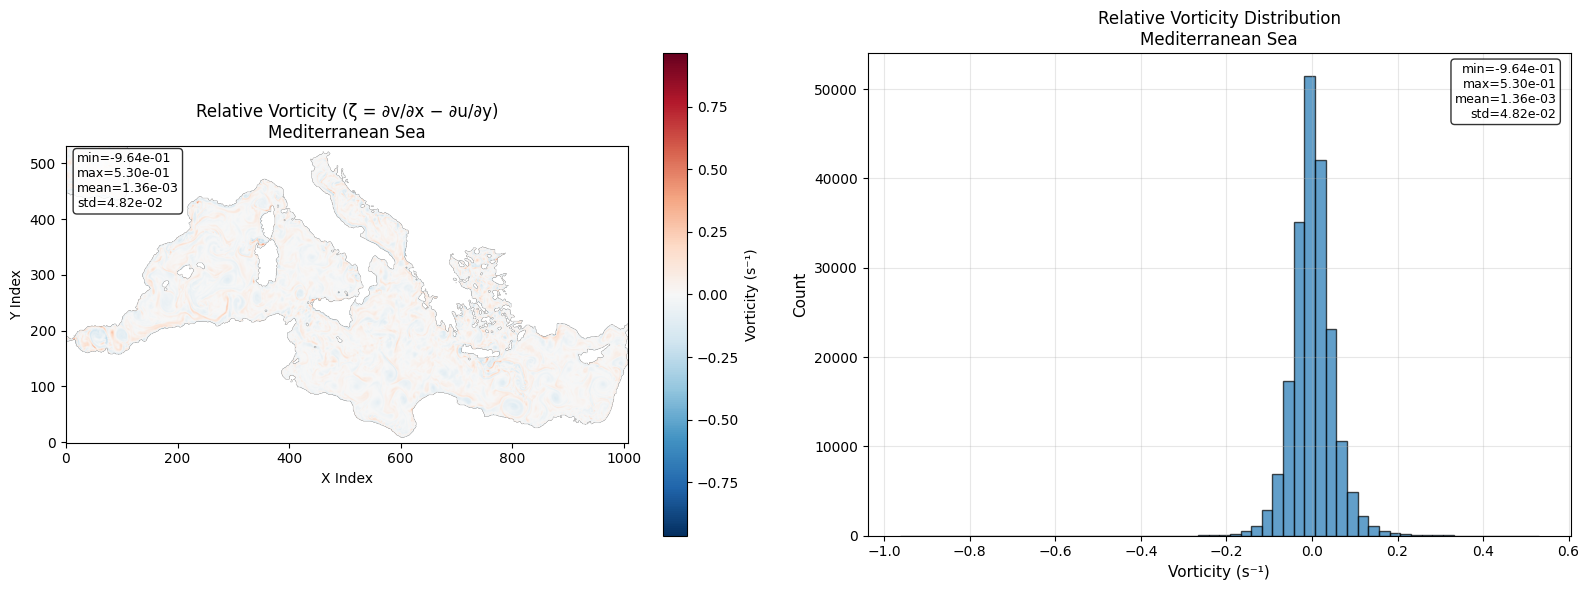

=== Vorticity Statistics (Mediterranean Sea) ===
  Min: -9.638574e-01 s⁻¹
  Max: 5.301249e-01 s⁻¹
  Mean: 1.357056e-03 s⁻¹
  Median: -5.456526e-05 s⁻¹
  Std: 4.819794e-02 s⁻¹


In [28]:
# Calculate vorticity (ζ = ∂v/∂x − ∂u/∂y) for Mediterranean Sea
# Using the u and v data from the previous cell

# Extract surface velocity components
u_surf = u_ocean[0, :, :]
v_surf = v_ocean[0, :, :]

# Calculate spatial derivatives
# ∂v/∂x: derivative of V in x-direction (eastward)
# ∂u/∂y: derivative of U in y-direction (northward)

# Use numpy gradient (returns derivatives in each dimension)
# For a 2D array: gradient returns [dy, dx]
dv_dy, dv_dx = np.gradient(v_surf)
du_dy, du_dx = np.gradient(u_surf)

# Relative vorticity: ζ = ∂v/∂x − ∂u/∂y
vorticity = dv_dx - du_dy

# Compute statistics
valid_vorticity = vorticity[~np.isnan(vorticity)]

vorticity_stats = {
    'min': np.min(valid_vorticity),
    'max': np.max(valid_vorticity),
    'mean': np.mean(valid_vorticity),
    'std': np.std(valid_vorticity),
    'median': np.median(valid_vorticity)
}

# Create visualization: Vorticity map + Vorticity histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Vorticity map with symmetric colorbar
vort_max = np.nanmax(np.abs(valid_vorticity))
im1 = ax1.imshow(vorticity, origin='lower', cmap='RdBu_r', vmin=-vort_max, vmax=vort_max)
ax1.set_title('Relative Vorticity (ζ = ∂v/∂x − ∂u/∂y)\nMediterranean Sea', fontsize=12)
ax1.set_xlabel('X Index')
ax1.set_ylabel('Y Index')
cbar1 = plt.colorbar(im1, ax=ax1, label='Vorticity (s⁻¹)')

# Add statistics text on vorticity plot
vort_text = f"min={vorticity_stats['min']:.2e}\nmax={vorticity_stats['max']:.2e}\nmean={vorticity_stats['mean']:.2e}\nstd={vorticity_stats['std']:.2e}"
ax1.text(0.02, 0.98, vort_text, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Vorticity histogram
ax2.hist(valid_vorticity, bins=60, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Vorticity (s⁻¹)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Relative Vorticity Distribution\nMediterranean Sea', fontsize=12)
ax2.grid(alpha=0.3)

# Add statistics text on histogram
vort_hist_text = f"min={vorticity_stats['min']:.2e}\nmax={vorticity_stats['max']:.2e}\nmean={vorticity_stats['mean']:.2e}\nstd={vorticity_stats['std']:.2e}"
ax2.text(0.98, 0.98, vort_hist_text, transform=ax2.transAxes, 
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"=== Vorticity Statistics (Mediterranean Sea) ===")
print(f"  Min: {vorticity_stats['min']:.6e} s⁻¹")
print(f"  Max: {vorticity_stats['max']:.6e} s⁻¹")
print(f"  Mean: {vorticity_stats['mean']:.6e} s⁻¹")
print(f"  Median: {vorticity_stats['median']:.6e} s⁻¹")
print(f"  Std: {vorticity_stats['std']:.6e} s⁻¹")

# Store results
vorticity_result = {
    'vorticity': vorticity,
    'statistics': vorticity_stats
}